In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 正解データ生成
def makeLabels(X, x1=0.35, y1=0.35, r1=0.3, x2=0.65, y2=0.65, r2=0.3):
    # 円1：中心 (0.35, 0.35), 半径 0.3 の円
    # 円2：中心 (0.65, 0.65), 半径 0.3 の円
    # 円1 と 円2 どちらかに（のみ）入っているならば 1、そうでなければ 0
    chk1 = np.less_equal(np.linalg.norm(X - np.array([x1, y1]), axis=1), r1)
    chk2 = np.less_equal(np.linalg.norm(X - np.array([x2, y2]), axis=1), r2)
    return np.where(np.logical_xor(chk1, chk2), 1.0, 0.0)

In [3]:
# サンプルデータ（訓練データ）生成
def makeData(N=1000):
    data = np.random.rand(N, 2)
    labels = makeLabels(data)
    return np.hstack([data, labels.reshape((N, 1))])

In [4]:
N = 10000
data = makeData(N=N)

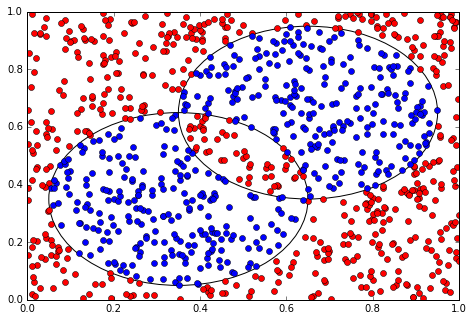

In [5]:
subdata = data[0:1000, :]
data0 = subdata[subdata[:,2]==0]
data1 = subdata[subdata[:,2]==1]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
c1 = plt.Circle((0.35, 0.35), 0.3, fill=False)
c2 = plt.Circle((0.65, 0.65), 0.3, fill=False)
ax.add_patch(c1)
ax.add_patch(c2)
plt.plot(data0[:,0], data0[:,1], "ro")
plt.plot(data1[:,0], data1[:,1], "bo")

## TensorFlow

In [6]:
def makeXMat(X0):
    N = np.size(X0, 0)
    X = X0 * 2.0 - 1.0
    return np.hstack((X, X**2, np.product(X, axis=1).reshape(N, 1)))

In [7]:
# X = data[:,0:2] * 2.0 - 1.0; Y = data[:, 2]
X = makeXMat(data[:,0:2]); Y = data[:, 2]

In [8]:
import tensorflow as tf

In [9]:
# # 訓練データ：長さ2のベクトルデータ
# x = tf.placeholder(tf.float32, [None, 2])
# 訓練データ：長さ5のベクトルデータ
x = tf.placeholder(tf.float32, [None, 5])
# 正解データ：0 or 1 のスカラー値
d = tf.placeholder(tf.float32, (None, 1))

In [10]:
# W1 = tf.Variable(tf.random_uniform([2, 4], -1.0, 1.0))
W1 = tf.Variable(tf.random_uniform([5, 4], -1.0, 1.0))
b1 = tf.Variable(tf.random_uniform([4], -1.0, 1.0))
z1 = tf.nn.tanh(tf.matmul(x,  W1) + b1)

In [11]:
W2 = tf.Variable(tf.random_uniform([4, 6], -1.0, 1.0))
b2 = tf.Variable(tf.random_uniform([6], -1.0, 1.0))
z2 = tf.nn.sigmoid(tf.matmul(z1, W2) + b2)

In [12]:
W3 = tf.Variable(tf.random_uniform([6, 4], -1.0, 1.0))
b3 = tf.Variable(tf.random_uniform([4], -1.0, 1.0))
z3 = tf.nn.sigmoid(tf.matmul(z2, W3) + b3)

In [13]:
W4 = tf.Variable(tf.random_uniform([4, 2], -1.0, 1.0))
b4 = tf.Variable(tf.random_uniform([2], -1.0, 1.0))
z4 = tf.matmul(z3, W4) + b4

In [14]:
y = tf.argmax(tf.nn.softmax(z4), 1)

In [15]:
x_entropy = tf.nn.softmax_cross_entropy_with_logits(z4, tf.concat(1, (1.0-d, d)))

In [16]:
optimizer = tf.train.GradientDescentOptimizer(0.03)
# optimizer = tf.train.AdagradOptimizer(0.1)
train_step = optimizer.minimize(x_entropy)

In [17]:
init = tf.initialize_all_variables()

In [18]:
# y（＝学習結果の出力）と d（正解データ）で一致しているかどうかを確認
correct_prediction = tf.equal(tf.cast(tf.reshape(y, [-1]), tf.float32), tf.reshape(d, [-1]))
# 平均（＝一致している個数÷全データ数）を計算
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [19]:
sess = tf.Session()
sess.run(init)
# ↑実際にはここで始めて各変数が初期化される

In [20]:
batch_size = 100
for i in range(1, 5001):
    randidx = np.random.choice(range(N), batch_size, replace=False)
    batch_xs = X[randidx, :]
    batch_ys = np.reshape(Y[randidx], (batch_size, 1))
    # _x = np.random.rand(100, 2)
    # # batch_xs = _x * 2.0 - 1.0
    # batch_xs = makeXMat(_x)
    # batch_ys = np.reshape(makeLabels(_x), (batch_size, 1))
    sess.run(train_step, feed_dict={x: batch_xs, d: batch_ys})
    if i % 100 == 0:
        print(sess.run(accuracy, feed_dict={x: X, d: Y.reshape(N, 1)}))

0.5863
0.8599
0.8993
0.8498
0.9119
0.9057
0.9113
0.907
0.8849
0.9116
0.9114
0.9192
0.9202
0.9071
0.9232
0.9256
0.8977
0.9229
0.9264
0.9247
0.9079
0.9208
0.9342
0.8281
0.9328
0.9603
0.9488
0.9521
0.9654
0.9726
0.9672
0.9644
0.9743
0.9788
0.9741
0.9734
0.9635
0.9789
0.9518
0.9837
0.9866
0.9797
0.9882
0.974
0.9854
0.9848
0.9733
0.9627
0.9598
0.9781


In [21]:
Yd = np.reshape(sess.run(y, feed_dict={x: X, d: Y.reshape(N, 1)}), (N,))

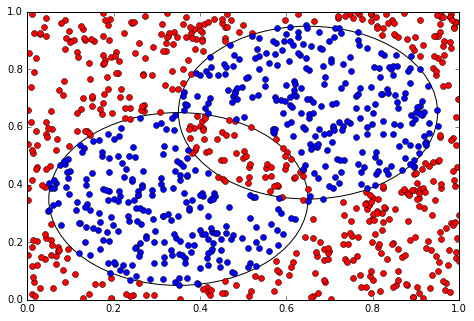

In [22]:
subdata = data[0:1000, :]
subYd = Yd[0:1000]
data0 = subdata[subYd<0.5]
data1 = subdata[subYd>=0.5]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
c1 = plt.Circle((0.35, 0.35), 0.3, fill=False)
c2 = plt.Circle((0.65, 0.65), 0.3, fill=False)
ax.add_patch(c1)
ax.add_patch(c2)
plt.plot(data0[:,0], data0[:,1], "ro")
plt.plot(data1[:,0], data1[:,1], "bo")

In [23]:
tp = np.sum(Y[Yd>=0.5])
fp = np.sum(1-Y[Yd>=0.5])
tn = np.sum(1-Y[Yd<0.5])
fn = np.sum(Y[Yd<0.5])
np.array([[tp,fp],[fn,tn]])

array([[ 4551.,   156.],
       [   63.,  5230.]])

In [24]:
accuracy = (tp + tn) / (tp + fp + fn + tn)
print("accuracy: %.06f" % accuracy)

accuracy: 0.978100


In [25]:
precision = tp / (tp + fp)
print("precision: %.06f" % precision)

precision: 0.966858


In [26]:
recall = tp / (tp + fn)
print("recall: %.06f" % recall)

recall: 0.986346


In [27]:
f_measure = 2 * precision * recall / (precision + recall)
print("f_measure: %.06f" % f_measure)

f_measure: 0.976505


In [28]:
# H = lambda _x: sess.run(tf.reshape(y, [-1]), feed_dict={x: _x * 2.0 - 1.0})
H = lambda _x: sess.run(tf.reshape(y, [-1]), feed_dict={x: makeXMat(_x)})

In [29]:
x_test = np.random.rand(100, 2)
y_test = H(x_test)

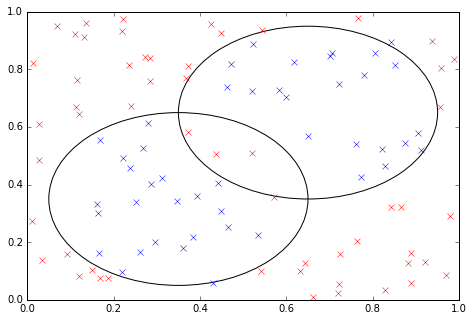

In [30]:
data0 = x_test[y_test==0]
data1 = x_test[y_test==1]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
c1 = plt.Circle((0.35, 0.35), 0.3, fill=False)
c2 = plt.Circle((0.65, 0.65), 0.3, fill=False)
ax.add_patch(c1)
ax.add_patch(c2)
plt.plot(data0[:,0], data0[:,1], "rx")
plt.plot(data1[:,0], data1[:,1], "bx")

In [31]:
labels = makeLabels(x_test)
tp = np.sum(labels[y_test==1])
fp = np.sum(1-labels[y_test==1])
tn = np.sum(1-labels[y_test==0])
fn = np.sum(labels[y_test==0])
np.array([[tp,fp],[fn,tn]])

array([[ 43.,   2.],
       [  1.,  54.]])

In [32]:
accuracy = (tp + tn) / (tp + fp + fn + tn)
print("accuracy: %.06f" % accuracy)

accuracy: 0.970000


In [33]:
precision = tp / (tp + fp)
print("precision: %.06f" % precision)

precision: 0.955556


In [34]:
recall = tp / (tp + fn)
print("recall: %.06f" % recall)

recall: 0.977273


In [35]:
f_measure = 2 * precision * recall / (precision + recall)
print("f_measure: %.06f" % f_measure)

f_measure: 0.966292
